In [6]:
# ============================================================
# SmartHome: Living / Japanese
# 入力：対象部屋に設置された家電・センサーだけ（エアコン/空気清浄機/M5Stack/PIR）
# タスク：在不在（0/1）と人数（0/1/2）を「別モデル」で学習
# 分割：時系列 split（shuffleしない）でリーク抑制
# 出力：各epochの train/val loss と lr
# 重要度：Permutation Importance（test上で accuracy低下量）
#
# ✅ NaN/inf対策込み（loss=nan を止める）
# ✅ 分散0（一定値）列の自動除去
# ✅ 列名揺れ対策：startswith & contains 両方で拾う
# ============================================================

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# ------------------------------------------------------------
# 0) 設定
# ------------------------------------------------------------
CSV_PATH = "./smart_home_features_added.csv"

# 部屋ごとの “使ってよい” デバイス/センサー識別トークン
# ※列名に以下の文字列が「含まれる」 or 「先頭一致」する列だけを使う
ROOMS = {
    "Living": {
        "count_label": "Label_Living_Count",
        "tokens": [
            # Living aircon
            "C0A80367-013001_",
            # Living air purifier
            "C0A8033B-013501",
            # M5Stack
            "M5Stack2",
            "M5Stack8",
            # PIR
            "PIR1",
            "PIR2",
            "PIR3",
            "PIR4",
            "PIR18",
        ],
    },
    "Japanese": {
        "count_label": "Label_Japanese_Count",
        "tokens": [
            # Japanese aircon
            "C0A80368-013001_",
            # Japanese air purifier
            "C0A80341-013501",
            # M5Stack
            "M5Stack1",
            # PIR
            "PIR17",
            "PIR21",
        ],
    },
}

# 時系列 split 比率（例：70% train / 15% val / 15% test）
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15

# 学習設定
SEED = 42
EPOCHS = 30
BATCH_SIZE = 256
LR = 1e-3
WEIGHT_DECAY = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Permutation importance 設定
PERM_REPEAT = 3

np.random.seed(SEED)
torch.manual_seed(SEED)

# ------------------------------------------------------------
# 1) データ読み込み + 安全な欠損処理（超重要）
# ------------------------------------------------------------
df = pd.read_csv(CSV_PATH, low_memory=False)

# timestampがあるなら時系列ソート
if "timestamp" in df.columns:
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
    df = df.sort_values("timestamp").reset_index(drop=True)

# ✅ NaN/inf対策（loss=nanの主原因対策）
# 1) infをNaNに
df = df.replace([np.inf, -np.inf], np.nan)
# 2) 前後で埋める
df = df.bfill().ffill()
# 3) それでも残るNaNは0（最後の保険）
df = df.fillna(0)
# 4) FutureWarning対策（型推定）
df = df.infer_objects(copy=False)

# Label/Action列は特徴量に混ぜない（リーク＆文字列混入防止）
label_cols = [c for c in df.columns if c.startswith("Label_")]
action_cols = [c for c in df.columns if "Action" in c]


# ------------------------------------------------------------
# 2) 部屋ごとの特徴量列抽出（startswith & contains）
# ------------------------------------------------------------
def build_feature_cols(df_room: pd.DataFrame, tokens: list[str]) -> list[str]:
    # 数値/Boolだけに限定（文字列列を除去）
    numeric_cols = set(df_room.select_dtypes(include=["number", "bool"]).columns)

    cols = []
    for c in df_room.columns:
        if c in label_cols or c in action_cols:
            continue
        if c not in numeric_cols:
            continue

        # token一致（startswith または contains）
        if any(c.startswith(t) for t in tokens) or any(t in c for t in tokens):
            cols.append(c)

    # bool -> int
    for c in cols:
        if df_room[c].dtype == bool:
            df_room[c] = df_room[c].astype(int)

    # 重複除去（順序維持）
    seen = set()
    uniq = []
    for c in cols:
        if c not in seen:
            uniq.append(c)
            seen.add(c)
    return uniq


# ------------------------------------------------------------
# 3) Dataset / Model（単一タスク分類：在不在 or 人数）
# ------------------------------------------------------------
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]


class MLPClassifier(nn.Module):
    def __init__(self, in_dim, n_class, hidden=128, dropout=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, n_class),
        )

    def forward(self, x):
        return self.net(x)


# ------------------------------------------------------------
# 4) 学習 / 予測
# ------------------------------------------------------------
def fit_mlp_classifier(X_train, y_train, X_val, y_val, n_class: int, title: str):
    model = MLPClassifier(in_dim=X_train.shape[1], n_class=n_class).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

    train_loader = DataLoader(
        TabularDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True
    )
    val_loader = DataLoader(
        TabularDataset(X_val, y_val), batch_size=BATCH_SIZE, shuffle=False
    )

    best_val = float("inf")
    best_state = None

    print(f"\n[{title}] optimizer=AdamW lr={LR} weight_decay={WEIGHT_DECAY}")
    print(f"[{title}] loss=CrossEntropyLoss")

    for epoch in range(1, EPOCHS + 1):
        # ---- train ----
        model.train()
        tr_losses = []
        for xb, yb in train_loader:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)

            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)

            # もしここでNaNが出たらデータ側がまだ壊れている
            if not torch.isfinite(loss):
                print(
                    f"[{title}] ERROR: loss is not finite (NaN/inf). Check X for NaN/inf."
                )
                return model

            loss.backward()
            optimizer.step()
            tr_losses.append(loss.item())

        # ---- val ----
        model.eval()
        va_losses = []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(DEVICE)
                yb = yb.to(DEVICE)
                logits = model(xb)
                loss = criterion(logits, yb)
                va_losses.append(loss.item())

        tr = float(np.mean(tr_losses)) if len(tr_losses) else np.nan
        va = float(np.mean(va_losses)) if len(va_losses) else np.nan
        print(
            f"[{title}][Epoch {epoch:02d}] train_loss={tr:.4f} val_loss={va:.4f} (lr={optimizer.param_groups[0]['lr']:.2e})"
        )

        if va < best_val:
            best_val = va
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

    if best_state is not None:
        model.load_state_dict(best_state)
    return model


def predict(model, X):
    model.eval()
    # ダミーy（未使用）
    loader = DataLoader(
        TabularDataset(X, np.zeros(len(X), dtype=int)),
        batch_size=BATCH_SIZE,
        shuffle=False,
    )
    preds = []
    with torch.no_grad():
        for xb, _ in loader:
            xb = xb.to(DEVICE)
            logits = model(xb)
            pred = torch.argmax(logits, dim=1).cpu().numpy()
            preds.append(pred)
    return np.concatenate(preds)


# ------------------------------------------------------------
# 5) Permutation Importance（accuracy低下量）
# ------------------------------------------------------------
def permutation_importance_accuracy(
    model, X_test, y_test, feature_cols, n_repeat=3, seed=0
):
    rng = np.random.default_rng(seed)
    base_pred = predict(model, X_test)
    base_acc = accuracy_score(y_test, base_pred)

    importances = []
    X_work = X_test.copy()

    for j in range(X_test.shape[1]):
        drops = []
        for _ in range(n_repeat):
            saved = X_work[:, j].copy()
            rng.shuffle(X_work[:, j])
            pred = predict(model, X_work)
            acc = accuracy_score(y_test, pred)
            drops.append(base_acc - acc)
            X_work[:, j] = saved
        importances.append(float(np.mean(drops)))

    imp = pd.DataFrame(
        {
            "feature": feature_cols,
            "importance_drop_acc": importances,
        }
    ).sort_values("importance_drop_acc", ascending=False)

    return base_acc, imp


# ------------------------------------------------------------
# 6) デバッグ：NaN/inf/分散0チェック（原因特定に効く）
# ------------------------------------------------------------
def debug_feature_quality(df_room, feature_cols, room_name, task_name):
    Xd = df_room[feature_cols].copy()

    nan_counts = Xd.isna().sum().sort_values(ascending=False)
    inf_counts = np.isinf(Xd.to_numpy()).sum(axis=0)
    inf_series = pd.Series(inf_counts, index=feature_cols).sort_values(ascending=False)

    print(f"\n[DEBUG][{room_name}][{task_name}] NaN top5:")
    print(nan_counts.head(5).to_string())
    print(f"[DEBUG][{room_name}][{task_name}] inf top5:")
    print(inf_series.head(5).to_string())


# ------------------------------------------------------------
# 7) メイン：部屋ごとに
#    - 在不在（2クラス）
#    - 人数（3クラス）
#    を別々に学習＆重要度算出
# ------------------------------------------------------------
for room_name, cfg in ROOMS.items():
    label_col = cfg["count_label"]
    tokens = cfg["tokens"]

    if label_col not in df.columns:
        print(f"[SKIP] {room_name}: label not found: {label_col}")
        continue

    # 実験条件：0/1/2 のみ使う（それ以外があれば除外）
    valid = df[label_col].isin([0, 1, 2])
    df_room = df.loc[valid].reset_index(drop=True)

    # 特徴量列抽出
    feature_cols = build_feature_cols(df_room, tokens)
    if len(feature_cols) == 0:
        print(
            f"[ERROR] {room_name}: feature_cols empty. tokensが列名と合ってない可能性。"
        )
        print("  tokens =", tokens)
        continue

    # 分散0（一定値）列を落とす（学習に不要＆不安定要因）
    std = df_room[feature_cols].std(numeric_only=True)
    const_cols = std[std == 0].index.tolist()
    if const_cols:
        print(
            f"[INFO] {room_name}: drop constant cols ({len(const_cols)}): {const_cols}"
        )
        feature_cols = [c for c in feature_cols if c not in const_cols]

    if len(feature_cols) == 0:
        print(f"[ERROR] {room_name}: all features became constant and were dropped.")
        continue

    # ラベル作成
    y_count = df_room[label_col].astype(int).values  # 0/1/2
    y_occ = (y_count > 0).astype(int)  # 0/1（在不在は別タスク）

    # 時系列 split（shuffleなし）
    N = len(df_room)
    tr_end = int(N * TRAIN_RATIO)
    va_end = int(N * (TRAIN_RATIO + VAL_RATIO))

    X_all = df_room[feature_cols].values

    X_tr, X_va, X_te = X_all[:tr_end], X_all[tr_end:va_end], X_all[va_end:]
    yc_tr, yc_va, yc_te = y_count[:tr_end], y_count[tr_end:va_end], y_count[va_end:]
    yo_tr, yo_va, yo_te = y_occ[:tr_end], y_occ[tr_end:va_end], y_occ[va_end:]

    # ✅ scalerは trainでfitのみ（リーク防止）
    scaler = StandardScaler()

    # ここで warning/NaN が起きるときは X_tr に NaN/inf が残ってることが多い
    # 追加の安全策：X_tr/X_va/X_te の inf を NaN にして0埋め（念のため）
    def sanitize_X(X):
        X = np.array(X, dtype=np.float32)
        X[~np.isfinite(X)] = 0.0
        return X

    X_tr = sanitize_X(X_tr)
    X_va = sanitize_X(X_va)
    X_te = sanitize_X(X_te)

    X_tr = scaler.fit_transform(X_tr)
    X_va = scaler.transform(X_va)
    X_te = scaler.transform(X_te)

    # さらに標準化後の NaN/inf も殺す（最後の保険）
    X_tr = sanitize_X(X_tr)
    X_va = sanitize_X(X_va)
    X_te = sanitize_X(X_te)

    print("\n" + "=" * 90)
    print(f"[ROOM] {room_name}")
    print(
        f"[INFO] label={label_col} | N={N} | train={len(X_tr)} val={len(X_va)} test={len(X_te)}"
    )
    print(f"[INFO] features={len(feature_cols)} (show first 15):")
    print(
        "  " + ", ".join(feature_cols[:15]) + (" ..." if len(feature_cols) > 15 else "")
    )
    print("=" * 90)

    # --------------------------------------------------------
    # (A) 在不在モデル（2クラス）
    # --------------------------------------------------------
    debug_feature_quality(
        df_room.iloc[:tr_end], feature_cols, room_name, "Occupancy(train-slice)"
    )

    occ_model = fit_mlp_classifier(
        X_tr, yo_tr, X_va, yo_va, n_class=2, title=f"{room_name}-Occupancy"
    )
    occ_pred = predict(occ_model, X_te)

    print(
        f"\n[{room_name}][TEST] Occupancy (0/1) acc = {accuracy_score(yo_te, occ_pred):.4f}"
    )
    print("Confusion matrix:\n", confusion_matrix(yo_te, occ_pred))
    print("Report:\n", classification_report(yo_te, occ_pred, zero_division=0))

    base_acc_occ, imp_occ = permutation_importance_accuracy(
        occ_model, X_te, yo_te, feature_cols, n_repeat=PERM_REPEAT, seed=SEED
    )
    print(
        f"\n[{room_name}] Occupancy Permutation Importance (Top 15) | base_acc={base_acc_occ:.4f}"
    )
    print(imp_occ.head(15).to_string(index=False))

    # --------------------------------------------------------
    # (B) 人数モデル（3クラス：0/1/2）
    # --------------------------------------------------------
    debug_feature_quality(
        df_room.iloc[:tr_end], feature_cols, room_name, "Count(train-slice)"
    )

    cnt_model = fit_mlp_classifier(
        X_tr, yc_tr, X_va, yc_va, n_class=3, title=f"{room_name}-Count(0/1/2)"
    )
    cnt_pred = predict(cnt_model, X_te)

    print(
        f"\n[{room_name}][TEST] Count (0/1/2) acc = {accuracy_score(yc_te, cnt_pred):.4f}"
    )
    print("Confusion matrix:\n", confusion_matrix(yc_te, cnt_pred))
    print("Report:\n", classification_report(yc_te, cnt_pred, zero_division=0))

    base_acc_cnt, imp_cnt = permutation_importance_accuracy(
        cnt_model, X_te, yc_te, feature_cols, n_repeat=PERM_REPEAT, seed=SEED
    )
    print(
        f"\n[{room_name}] Count Permutation Importance (Top 15) | base_acc={base_acc_cnt:.4f}"
    )
    print(imp_cnt.head(15).to_string(index=False))

print("\n[DONE] finished.")

/var/folders/vb/8k_9t5_n3sng20r8pshmdzmr0000gn/T/ipykernel_20889/3407695055.py:98: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.bfill().ffill()


[INFO] Living: drop constant cols (7): ['C0A8033B-013501_opStatus', 'C0A8033B-013501_flow', 'C0A80367-013001_mode', 'C0A80367-013001_blowTemp', 'C0A80367-013001_flow', 'C0A80367-013001_blowTemp_rate', 'C0A80367-013001_blowTemp_rate_smooth']

[ROOM] Living
[INFO] label=Label_Living_Count | N=13606 | train=9524 val=2041 test=2041
[INFO] features=72 (show first 15):
  PIR1_motion, PIR2_motion, PIR3_motion, PIR4_motion, PIR18_motion, PIR13_motion, PIR11_motion, PIR21_motion, PIR17_motion, PIR10_motion, PIR15_motion, PIR19_motion, PIR20_motion, PIR22_motion, PIR24_motion ...

[DEBUG][Living][Occupancy(train-slice)] NaN top5:
PIR1_motion                 0
PIR2_motion                 0
M5Stack8_co2_rate           0
M5Stack2_voc_rate_smooth    0
M5Stack2_voc_rate           0
[DEBUG][Living][Occupancy(train-slice)] inf top5:
PIR1_motion                 0
PIR2_motion                 0
M5Stack8_co2_rate           0
M5Stack2_voc_rate_smooth    0
M5Stack2_voc_rate           0

[Living-Occupancy] op

In [9]:
# ============================================================
# RandomForest版
# - Living / Japanese を部屋ごとに学習
# - 入力：対象部屋に設置された家電・センサーだけ（エアコン/空気清浄機/M5Stack/PIR）
# - タスク：在不在（0/1）と人数（0/1/2）を別モデル
# - 分割：時系列 split（shuffleしない）でリーク抑制
# - test(正解データ)は学習/前処理で見ない（fitはtrainだけ）
# - 特徴量重要度：Permutation Importance（推奨） + RF組み込み(Gini)
# ============================================================

import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.inspection import permutation_importance

# ------------------------------------------------------------
# 0) 設定
# ------------------------------------------------------------
CSV_PATH = "./smart_home_features_added.csv"

ROOMS = {
    "Living": {
        "count_label": "Label_Living_Count",
        "tokens": [
            "C0A80367-013001_",  # Living aircon
            "C0A8033B-013501",  # Living air purifier
            "M5Stack2",
            "M5Stack8",
            "PIR1",
            "PIR2",
            "PIR3",
            "PIR4",
            "PIR18",
        ],
    },
    "Japanese": {
        "count_label": "Label_Japanese_Count",
        "tokens": [
            "C0A80368-013001_",  # Japanese aircon
            "C0A80341-013501",  # Japanese air purifier
            "M5Stack1",
            "PIR17",
            "PIR21",
        ],
    },
}

TRAIN_RATIO = 0.70
VAL_RATIO = 0.15  # RFではvalを必須にしないが、同じsplitを維持（testを厳密に隔離）

SEED = 42

# RF設定（必要なら調整）
RF_COMMON = dict(
    n_estimators=600,
    random_state=SEED,
    n_jobs=-1,
    max_depth=None,
    min_samples_leaf=2,
    class_weight="balanced_subsample",  # クラス不均衡に少し強く
)

# Permutation importance
PERM_REPEAT = 5

# ------------------------------------------------------------
# 1) データ読み込み + NaN/inf対策
# ------------------------------------------------------------
df = pd.read_csv(CSV_PATH, low_memory=False)

if "timestamp" in df.columns:
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
    df = df.sort_values("timestamp").reset_index(drop=True)

df = df.replace([np.inf, -np.inf], np.nan)
df = df.bfill().ffill()
df = df.fillna(0)
df = df.infer_objects(copy=False)

label_cols = [c for c in df.columns if c.startswith("Label_")]
action_cols = [c for c in df.columns if "Action" in c]


# ------------------------------------------------------------
# 2) 特徴量列抽出（startswith & contains 両対応）
# ------------------------------------------------------------
def build_feature_cols(df_room: pd.DataFrame, tokens: list[str]) -> list[str]:
    numeric_cols = set(df_room.select_dtypes(include=["number", "bool"]).columns)

    cols = []
    for c in df_room.columns:
        if c in label_cols or c in action_cols:
            continue
        if c not in numeric_cols:
            continue
        if any(c.startswith(t) for t in tokens) or any(t in c for t in tokens):
            cols.append(c)

    # bool -> int
    for c in cols:
        if df_room[c].dtype == bool:
            df_room[c] = df_room[c].astype(int)

    # 重複除去
    seen = set()
    uniq = []
    for c in cols:
        if c not in seen:
            uniq.append(c)
            seen.add(c)
    return uniq


def sanitize_X(X):
    X = np.array(X, dtype=np.float32)
    X[~np.isfinite(X)] = 0.0
    return X


# ------------------------------------------------------------
# 3) 学習・評価（testを絶対に学習に使わない）
# ------------------------------------------------------------
def train_eval_rf(
    room_name: str,
    df_room: pd.DataFrame,
    feature_cols: list[str],
    y,
    task_name: str,
    n_class: int,
):
    """
    df_room: 既に時系列順 & 対象ラベルだけ残したDF
    y: 目的変数（np.array）
    """
    N = len(df_room)
    tr_end = int(N * TRAIN_RATIO)
    va_end = int(N * (TRAIN_RATIO + VAL_RATIO))

    X_all = sanitize_X(df_room[feature_cols].values)

    # ✅ 時系列split（shuffleしない）
    X_tr, X_va, X_te = X_all[:tr_end], X_all[tr_end:va_end], X_all[va_end:]
    y_tr, y_va, y_te = y[:tr_end], y[tr_end:va_end], y[va_end:]

    # ✅ ここが重要：fitはtrainだけ（testは一切使わない）
    model = RandomForestClassifier(**RF_COMMON)
    model.fit(X_tr, y_tr)

    # 評価（valは参考、testが本番）
    pred_te = model.predict(X_te)

    print(
        f"\n[{room_name}][{task_name}][TEST] acc = {accuracy_score(y_te, pred_te):.4f}"
    )
    print("Confusion matrix:\n", confusion_matrix(y_te, pred_te))
    print("Report:\n", classification_report(y_te, pred_te, zero_division=0))

    # --- 重要度1：RF組み込み（Gini重要度） ---
    gini = pd.DataFrame(
        {"feature": feature_cols, "gini_importance": model.feature_importances_}
    ).sort_values("gini_importance", ascending=False)

    print(f"\n[{room_name}][{task_name}] RF Gini importance (Top 15)")
    print(gini.head(15).to_string(index=False))

    # --- 重要度2：Permutation Importance（推奨 / testで計算） ---
    # ※testを“学習に使わない”のは守ったまま、評価として重要度を算出
    perm = permutation_importance(
        model,
        X_te,
        y_te,
        n_repeats=PERM_REPEAT,
        random_state=SEED,
        n_jobs=-1,
        scoring="accuracy",
    )

    perm_df = pd.DataFrame(
        {
            "feature": feature_cols,
            "perm_importance_mean_drop_acc": perm.importances_mean,
            "perm_importance_std": perm.importances_std,
        }
    ).sort_values("perm_importance_mean_drop_acc", ascending=False)

    print(f"\n[{room_name}][{task_name}] Permutation importance on TEST (Top 15)")
    print(perm_df.head(15).to_string(index=False))

    return model


# ------------------------------------------------------------
# 4) メイン：部屋ごとに在不在RF & 人数RF
# ------------------------------------------------------------
for room_name, cfg in ROOMS.items():
    label_col = cfg["count_label"]
    tokens = cfg["tokens"]

    if label_col not in df.columns:
        print(f"[SKIP] {room_name}: label not found: {label_col}")
        continue

    # 実験条件：0/1/2 だけに限定
    valid = df[label_col].isin([0, 1, 2])
    df_room = df.loc[valid].reset_index(drop=True)

    feature_cols = build_feature_cols(df_room, tokens)
    if len(feature_cols) == 0:
        print(
            f"[ERROR] {room_name}: feature_cols empty. tokensが列名と合ってない可能性。"
        )
        print("  tokens =", tokens)
        continue

    # 分散0（一定値）列を落とす（RFでも不要）
    std = df_room[feature_cols].std(numeric_only=True)
    const_cols = std[std == 0].index.tolist()
    if const_cols:
        print(
            f"[INFO] {room_name}: drop constant cols ({len(const_cols)}): {const_cols}"
        )
        feature_cols = [c for c in feature_cols if c not in const_cols]

    if len(feature_cols) == 0:
        print(f"[ERROR] {room_name}: all features became constant and were dropped.")
        continue

    # ラベル作成
    y_count = df_room[label_col].astype(int).values  # 0/1/2
    y_occ = (y_count > 0).astype(int)  # 在不在 0/1（別タスク）

    print("\n" + "=" * 90)
    print(f"[ROOM] {room_name}")
    print(f"[INFO] label={label_col} | N={len(df_room)} | features={len(feature_cols)}")
    print(f"[INFO] features first 15: {feature_cols[:15]}")
    print("=" * 90)

    # (A) 在不在（2値）RF
    _ = train_eval_rf(
        room_name=room_name,
        df_room=df_room,
        feature_cols=feature_cols,
        y=y_occ,
        task_name="Occupancy(0/1)",
        n_class=2,
    )

    # (B) 人数（0/1/2）RF
    _ = train_eval_rf(
        room_name=room_name,
        df_room=df_room,
        feature_cols=feature_cols,
        y=y_count,
        task_name="Count(0/1/2)",
        n_class=3,
    )

print("\n[DONE] RandomForest finished.")

/var/folders/vb/8k_9t5_n3sng20r8pshmdzmr0000gn/T/ipykernel_20889/1608246423.py:78: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.bfill().ffill()


[INFO] Living: drop constant cols (7): ['C0A8033B-013501_opStatus', 'C0A8033B-013501_flow', 'C0A80367-013001_mode', 'C0A80367-013001_blowTemp', 'C0A80367-013001_flow', 'C0A80367-013001_blowTemp_rate', 'C0A80367-013001_blowTemp_rate_smooth']

[ROOM] Living
[INFO] label=Label_Living_Count | N=13606 | features=72
[INFO] features first 15: ['PIR1_motion', 'PIR2_motion', 'PIR3_motion', 'PIR4_motion', 'PIR18_motion', 'PIR13_motion', 'PIR11_motion', 'PIR21_motion', 'PIR17_motion', 'PIR10_motion', 'PIR15_motion', 'PIR19_motion', 'PIR20_motion', 'PIR22_motion', 'PIR24_motion']

[Living][Occupancy(0/1)][TEST] acc = 0.6193
Confusion matrix:
 [[1085    0]
 [ 777  179]]
Report:
               precision    recall  f1-score   support

           0       0.58      1.00      0.74      1085
           1       1.00      0.19      0.32       956

    accuracy                           0.62      2041
   macro avg       0.79      0.59      0.53      2041
weighted avg       0.78      0.62      0.54      2041

In [10]:
# ============================================================
# RandomForest / LightGBM
# - 時系列split（timestamp順：前をtrain、後ろをtest）
# - データ拡張（trainのみ）：ノイズ + タイムシフト
# - 追加特徴量（CO2/PM2.5/VOCなど数値系）
#    window = [5,10,15,20,25,30,60] 分で一括作成
#    - diff / slope / rolling mean/std / integral(sum)
#    - trend（rolling回帰傾き）
#    - monotonic_ratio（上昇している割合）
#    - acceleration（傾きの変化）
#    - area（基準値からの累積面積）
# - 各部屋（Living/Japanese）
# - 3条件を回す（要望対応）
#    A) all：家電 + センサー（M5Stack + PIR）
#    B) appliance_only：家電(C0A8033B/C0A80341/C0A80367/C0A80368)のみ（PIRなし）
#    C) no_co2_human：CO2とHuman(PIR/human)を除外した特徴（PM2.5/VOC/温湿度等）
# - 出力：Accuracy / BalancedAcc / F1macro / Confusion（matplotlib）
# - feature importance：各条件「全特徴」をCSV保存 + TopKをPNG保存（カレント直下）
# ============================================================

import os
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    confusion_matrix,
)
from sklearn.utils.class_weight import compute_class_weight

from lightgbm import LGBMClassifier


# =========================
# 設定
# =========================
CSV_PATH = "./smart_home_renamed_with_timestamp.csv"  # あなたが作ったtimestamp付きCSV
TIME_COL = "timestamp"
RESAMPLE_RULE = "1min"  # 1分に揃える（特徴量が安定）
TRAIN_RATIO = 0.80  # 時系列split
RANDOM_STATE = 42

# データ拡張（trainのみ）
AUG_NOISE_LEVEL = 0.02
AUG_SHIFT_STEPS = [-1, 1]  # 1分ずらし
AUG_REPEAT_NOISE = 1  # ノイズを何回作るか

# 特徴量window
WINS = [5, 10, 15, 20, 25, 30, 60]

# importance描画
TOPK_IMPORTANCE = 30

# 目的変数は 0/1/2 に固定（それ以外は捨てる）
ALLOWED_Y = [0, 1, 2]

# 家電prefix（重要：あなたの要望の家電だけ）
APPLIANCE_PREFIXES = ("C0A8033B", "C0A80341", "C0A80367", "C0A80368")


# =========================
# ユーティリティ
# =========================
def to_dt(series: pd.Series) -> pd.Series:
    return pd.to_datetime(series, errors="coerce", infer_datetime_format=True)


def safe_ffill(df: pd.DataFrame) -> pd.DataFrame:
    # 未来を見ない：ffillのみ
    return df.ffill().infer_objects(copy=False)


def resample_1min(df: pd.DataFrame, rule="1min") -> pd.DataFrame:
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    other_cols = [c for c in df.columns if c not in num_cols]

    out = []
    if num_cols:
        out.append(df[num_cols].resample(rule).mean())
    if other_cols:
        out.append(df[other_cols].resample(rule).last())

    dfr = pd.concat(out, axis=1).sort_index()
    dfr = safe_ffill(dfr)
    return dfr


def time_split_idx(n: int, train_ratio: float):
    n_tr = int(n * train_ratio)
    tr_idx = np.arange(0, n_tr)
    te_idx = np.arange(n_tr, n)
    return tr_idx, te_idx


def coerce_boolish_to_float(s: pd.Series) -> pd.Series:
    s = s.replace({"True": 1, "False": 0, True: 1, False: 0})
    s = pd.to_numeric(s, errors="coerce")
    return s.astype(float)


def compact_metrics(y_true, y_pred, labels):
    acc = accuracy_score(y_true, y_pred)
    bacc = balanced_accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro")
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    return acc, bacc, f1m, cm


def plot_confusion_mat(cm, labels, title, save_png):
    plt.figure(figsize=(5.2, 4.2))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")

    # annotate
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i, j]), ha="center", va="center")

    plt.tight_layout()
    plt.savefig(save_png, dpi=200)
    plt.close()
    print(f"[Saved] {save_png}")


def save_importance_csv_and_plot(feature_names, importances, title, tag, topk=30):
    """
    feature importanceを
    - 全特徴CSV保存
    - 上位topkをPNG保存
    """
    imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    csv_path = f"{tag}_importance.csv"
    imp.reset_index().rename(columns={"index": "feature", 0: "importance"}).to_csv(
        csv_path, index=False
    )
    print(f"[Saved] {csv_path}")

    s = imp.head(topk)[::-1]
    plt.figure(figsize=(10, max(4, 0.28 * len(s))))
    plt.barh(s.index, s.values)
    plt.title(f"{title} (Top{topk})")
    plt.xlabel("importance")
    plt.tight_layout()
    png_path = f"{tag}_importance.png"
    plt.savefig(png_path, dpi=200)
    plt.close()
    print(f"[Saved] {png_path}")


def compute_sample_weight_from_y(y: np.ndarray):
    # 明示 class weight（sklearn系）
    classes = np.unique(y)
    cw = compute_class_weight(class_weight="balanced", classes=classes, y=y)
    cw_map = {c: w for c, w in zip(classes, cw)}
    return np.array([cw_map[v] for v in y], dtype=float)


# =========================
# 特徴量（数値系）生成
# =========================
def _rolling_linreg_slope(y: pd.Series, window: int) -> pd.Series:
    """
    rolling linear regression slope over last `window` points.
    equally spaced (1min). unit: value/min
    """
    y = pd.to_numeric(y, errors="coerce").astype(float)
    w = int(window)
    if w < 3:
        return pd.Series(0.0, index=y.index)

    t = np.arange(w, dtype=float)
    t_mean = t.mean()
    t_centered = t - t_mean
    denom = np.sum(t_centered**2)

    def slope_fn(a):
        a = np.asarray(a, dtype=float)
        a_mean = np.mean(a)
        return np.dot(t_centered, (a - a_mean)) / denom

    return y.rolling(w, min_periods=w).apply(slope_fn, raw=True).fillna(0.0)


def _monotonic_ratio(y: pd.Series, window: int) -> pd.Series:
    y = pd.to_numeric(y, errors="coerce").astype(float)
    d = y.diff()
    pos = (d > 0).astype(float)
    return pos.rolling(window, min_periods=1).mean().fillna(0.0)


def _area_from_baseline(y: pd.Series, window: int) -> pd.Series:
    y = pd.to_numeric(y, errors="coerce").astype(float)
    base = y.rolling(window, min_periods=1).min()
    area = (y - base).rolling(window, min_periods=1).sum()
    return area.fillna(0.0)


def build_numeric_features_multiwin(
    df: pd.DataFrame, cols: list[str], wins: list[int]
) -> pd.DataFrame:
    """
    任意の数値列に対し、winsに対する特徴量を一気に作成。
    """
    feats = {}
    for c in cols:
        if c not in df.columns:
            continue
        s = pd.to_numeric(df[c], errors="coerce").astype(float).ffill()

        # raw
        feats[c] = s

        # 1min diff
        feats[f"{c}_diff_1min"] = s.diff().fillna(0.0)

        for w in wins:
            # rolling stats
            feats[f"{c}_mean_{w}min"] = s.rolling(w, min_periods=1).mean().fillna(0.0)
            feats[f"{c}_std_{w}min"] = s.rolling(w, min_periods=1).std().fillna(0.0)

            # slope approx (ppm/min等)
            feats[f"{c}_slope_{w}min"] = ((s - s.shift(w)) / float(w)).fillna(0.0)

            # integral (sum over window)
            feats[f"{c}_integral_{w}min"] = (
                s.rolling(w, min_periods=1).sum().fillna(0.0)
            )

            # trend via rolling regression (requested)
            feats[f"{c}_trend_{w}min"] = _rolling_linreg_slope(s, w)

            # monotonic ratio
            feats[f"{c}_monotonic_ratio_{w}min"] = _monotonic_ratio(s, w)

            # area from baseline
            feats[f"{c}_area_{w}min"] = _area_from_baseline(s, w)

            # acceleration: slope change（短窓-長窓っぽい差分）
            # ここでは「1min diffのw分平均との差」を簡易加速度として入れる
            diff = feats[f"{c}_diff_1min"]
            feats[f"{c}_accel_{w}min"] = (
                diff - diff.rolling(w, min_periods=1).mean()
            ).fillna(0.0)

    X = pd.DataFrame(feats, index=df.index)
    X = X.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    return X


def build_human_features(
    df: pd.DataFrame, human_cols: list[str], wins: list[int]
) -> pd.DataFrame:
    """
    human / PIR など boolish を数値化して rolling sum を付与
    """
    feats = {}
    for c in human_cols:
        if c not in df.columns:
            continue
        s = coerce_boolish_to_float(df[c]).ffill().fillna(0.0)
        feats[c] = s
        for w in wins:
            feats[f"{c}_sum_{w}min"] = s.rolling(w, min_periods=1).sum().fillna(0.0)
    X = pd.DataFrame(feats, index=df.index)
    X = X.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    return X


# =========================
# 列選択（部屋ごと）
# =========================
def is_pm25(name: str) -> bool:
    n = name.lower()
    return ("pm2_5" in n) or ("pm2.5" in n) or ("pm25" in n)


def is_co2(name: str) -> bool:
    return name.lower().endswith("_co2") or ("_co2_" in name.lower())


def is_voc(name: str) -> bool:
    return "voc" in name.lower()


def is_human_like(name: str) -> bool:
    n = name.lower()
    return ("pir" in n) or n.endswith("_human") or ("motion" in n)


def is_temp_hum_like(name: str) -> bool:
    n = name.lower()
    return ("_temp" in n) or ("temp" in n) or ("_hum" in n) or ("humid" in n)


def uniq(xs):
    return list(dict.fromkeys(xs))


def pick_room_columns(df: pd.DataFrame, room: str):
    """
    Living:
      - label: Label_Living_Count
      - house appliances: C0A80367-013001_ (AC), C0A8033B-013501_ (purifier)
      - sensors: M5Stack1/2/8 + PIR*
    Japanese:
      - label: Label_Japanese_Count
      - appliances: C0A80368-013001_ (AC), C0A80341-013501_ (purifier)
      - sensors: M5Stack1/2/8 + PIR*
    """
    if room == "Living":
        label = "Label_Living_Count"
        appliance_cols = [
            c
            for c in df.columns
            if c.startswith("C0A80367-013001_") or c.startswith("C0A8033B-013501_")
        ]
    elif room == "Japanese":
        label = "Label_Japanese_Count"
        appliance_cols = [
            c
            for c in df.columns
            if c.startswith("C0A80368-013001_") or c.startswith("C0A80341-013501_")
        ]
    else:
        raise ValueError("room must be Living or Japanese")

    # M5Stack subset（要求：1/2/8）
    m5_cols = [
        c
        for c in df.columns
        if (
            c.startswith("M5Stack1_")
            or c.startswith("M5Stack2_")
            or c.startswith("M5Stack8_")
        )
    ]

    # PIR cols（そのまま拾う）
    pir_cols = [c for c in df.columns if c.lower().startswith("pir")]

    # 数値センサ系（部屋に関係しそうなもの：家電 + M5Stack）
    candidate_num = appliance_cols + m5_cols

    co2_cols = [c for c in candidate_num if is_co2(c)]
    pm25_cols = [c for c in candidate_num if is_pm25(c)]
    voc_cols = [c for c in candidate_num if is_voc(c)]
    th_cols = [c for c in candidate_num if is_temp_hum_like(c)]  # temp/hum

    # human系：家電human + PIR*
    human_cols = [c for c in candidate_num if c.lower().endswith("_human")] + pir_cols

    # appliance_only：家電prefixだけ（PIRなし）
    appliance_only = [c for c in df.columns if c.startswith(APPLIANCE_PREFIXES)]
    appliance_only_co2 = [c for c in appliance_only if is_co2(c)]
    appliance_only_pm25 = [c for c in appliance_only if is_pm25(c)]
    appliance_only_voc = [c for c in appliance_only if is_voc(c)]
    appliance_only_th = [c for c in appliance_only if is_temp_hum_like(c)]
    appliance_only_human = [c for c in appliance_only if c.lower().endswith("_human")]

    pack = dict(
        label=label,
        # all
        co2_cols=uniq([c for c in co2_cols if c in df.columns]),
        pm25_cols=uniq([c for c in pm25_cols if c in df.columns]),
        voc_cols=uniq([c for c in voc_cols if c in df.columns]),
        th_cols=uniq([c for c in th_cols if c in df.columns]),
        human_cols=uniq([c for c in human_cols if c in df.columns]),
        # appliance_only
        app_co2=uniq([c for c in appliance_only_co2 if c in df.columns]),
        app_pm25=uniq([c for c in appliance_only_pm25 if c in df.columns]),
        app_voc=uniq([c for c in appliance_only_voc if c in df.columns]),
        app_th=uniq([c for c in appliance_only_th if c in df.columns]),
        app_human=uniq([c for c in appliance_only_human if c in df.columns]),
    )
    return pack


# =========================
# データ拡張（trainのみ）
# =========================
def augment_train_data(
    X: pd.DataFrame,
    y: pd.Series,
    noise_level=0.02,
    shift_steps=(-1, 1),
    repeat_noise=1,
    random_state=42,
):
    rng = np.random.default_rng(random_state)

    # ★念のため：重複カラム除去（上でもやるが二重保険）
    X = X.loc[:, ~X.columns.duplicated()].copy()

    X_list = [X]
    y_list = [y.reset_index(drop=True)]

    # ★「実際に代入する数値列」をここで確定させる（ズレ防止）
    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    X_num = X[num_cols]  # これが真の形状

    # 1) ノイズ付加（repeat分だけ作る）
    for k in range(int(repeat_noise)):
        if len(num_cols) > 0:
            noise = rng.normal(0, noise_level, size=X_num.shape)
            Xn = X.copy()
            Xn.loc[:, num_cols] = X_num.values + noise
            X_list.append(Xn)
            y_list.append(y.reset_index(drop=True))

    # 2) タイムシフト
    for step in shift_steps:
        Xs = X.shift(step).ffill().bfill()
        X_list.append(Xs)
        y_list.append(y.reset_index(drop=True))

    X_aug = pd.concat(X_list, axis=0, ignore_index=True)
    y_aug = pd.concat(y_list, axis=0, ignore_index=True)

    return X_aug, y_aug


# =========================
# モデル学習（RF / LGBM）
# =========================
def train_and_eval_models(
    room: str, setting: str, df: pd.DataFrame, pack: dict, model_kind: str
):
    """
    model_kind: "rf" or "lgbm"
    setting:
      - "all"
      - "appliance_only"
      - "no_co2_human"
    """
    label_col = pack["label"]
    if label_col not in df.columns:
        print(f"[SKIP] {room}: label {label_col} not found")
        return

    # y整形（0/1/2のみ）
    y = pd.to_numeric(df[label_col], errors="coerce")
    y = y.where(y.isin(ALLOWED_Y), np.nan)
    y = y.ffill().fillna(0).astype(int)

    # columns choose
    if setting == "all":
        num_cols = (
            pack["co2_cols"] + pack["pm25_cols"] + pack["voc_cols"] + pack["th_cols"]
        )
        human_cols = pack["human_cols"]
    elif setting == "appliance_only":
        num_cols = pack["app_co2"] + pack["app_pm25"] + pack["app_voc"] + pack["app_th"]
        human_cols = pack["app_human"]  # PIRなし
    elif setting == "no_co2_human":
        # CO2とhumanを外す：PM2.5/VOC/温湿度等のみ（allベース）
        num_cols = pack["pm25_cols"] + pack["voc_cols"] + pack["th_cols"]
        human_cols = []  # PIR/humanはゼロ
    else:
        raise ValueError("setting invalid")

    num_cols = uniq([c for c in num_cols if c in df.columns])
    human_cols = uniq([c for c in human_cols if c in df.columns])

    # 特徴量生成
    X_num = (
        build_numeric_features_multiwin(df, num_cols, WINS)
        if len(num_cols)
        else pd.DataFrame(index=df.index)
    )
    X_hum = (
        build_human_features(df, human_cols, WINS)
        if len(human_cols)
        else pd.DataFrame(index=df.index)
    )
    X = (
        pd.concat([X_num, X_hum], axis=1)
        .replace([np.inf, -np.inf], np.nan)
        .ffill()
        .fillna(0.0)
    )

    X = X.loc[:, ~X.columns.duplicated()]
    # 時系列split
    tr_idx, te_idx = time_split_idx(len(df), TRAIN_RATIO)
    X_tr, X_te = X.iloc[tr_idx].reset_index(drop=True), X.iloc[te_idx].reset_index(
        drop=True
    )
    y_tr, y_te = y.iloc[tr_idx].reset_index(drop=True), y.iloc[te_idx].reset_index(
        drop=True
    )

    # train拡張（testは絶対拡張しない）
    X_tr_aug, y_tr_aug = augment_train_data(
        X_tr,
        y_tr,
        noise_level=AUG_NOISE_LEVEL,
        shift_steps=AUG_SHIFT_STEPS,
        repeat_noise=AUG_REPEAT_NOISE,
        random_state=RANDOM_STATE,
    )

    # class weight（明示）
    sw = compute_sample_weight_from_y(y_tr_aug.values)

    # train
    if model_kind == "rf":
        model = RandomForestClassifier(
            n_estimators=400,
            max_depth=None,
            min_samples_leaf=1,
            n_jobs=-1,
            random_state=RANDOM_STATE,
            class_weight=None,  # sample_weightで調整するため
        )
        model.fit(X_tr_aug, y_tr_aug, sample_weight=sw)
        y_pred = model.predict(X_te)

        # importance
        importances = model.feature_importances_
        imp_title = f"RF {room} / {setting} | feature importance"
    elif model_kind == "lgbm":
        # LightGBMログ抑制：verbose=-1
        # multi-class（0/1/2）
        model = LGBMClassifier(
            objective="multiclass",
            num_class=3,
            n_estimators=1200,
            learning_rate=0.03,
            num_leaves=63,
            subsample=0.9,
            colsample_bytree=0.9,
            reg_lambda=1.0,
            random_state=RANDOM_STATE,
            n_jobs=-1,
            verbose=-1,
        )
        model.fit(X_tr_aug, y_tr_aug, sample_weight=sw)
        y_pred = model.predict(X_te)

        booster = model.booster_
        importances = booster.feature_importance(importance_type="gain")
        imp_title = f"LGBM {room} / {setting} | feature importance (gain)"
    else:
        raise ValueError("model_kind invalid")

    # metrics
    acc, bacc, f1m, cm = compact_metrics(y_te, y_pred, labels=[0, 1, 2])

    print("\n" + "=" * 92)
    print(f"[{model_kind.upper()}] {room} | setting={setting}")
    print(
        f"features={X.shape[1]}  train={len(X_tr)}(+aug={len(X_tr_aug)})  test={len(X_te)}"
    )
    print(f"label dist test: {y_te.value_counts().to_dict()}")
    print("=" * 92)
    print(f"Accuracy     : {acc:.4f}")
    print(f"Balanced Acc : {bacc:.4f}")
    print(f"F1 (macro)   : {f1m:.4f}")
    print("Confusion Mat (rows=true, cols=pred):")
    print(cm)

    # save confusion
    cm_png = f"{model_kind}_{room}_{setting}_cm.png"
    plot_confusion_mat(
        cm,
        labels=[0, 1, 2],
        title=f"{model_kind.upper()} {room} {setting} Confusion",
        save_png=cm_png,
    )

    # save importance CSV+PNG
    tag = f"{model_kind}_{room}_{setting}"
    save_importance_csv_and_plot(
        feature_names=X.columns.tolist(),
        importances=importances,
        title=imp_title,
        tag=tag,
        topk=TOPK_IMPORTANCE,
    )


def run_room(df: pd.DataFrame, room: str):
    pack = pick_room_columns(df, room)

    # 3条件 × 2モデル（RF/LGBM）
    for setting in ["all", "appliance_only", "no_co2_human"]:
        train_and_eval_models(room, setting, df, pack, model_kind="rf")
        train_and_eval_models(room, setting, df, pack, model_kind="lgbm")


# =========================
# Main
# =========================
print("📥 Loading CSV...")
df0 = pd.read_csv(CSV_PATH, low_memory=False)

# timestampが無い場合は「行順」を時系列として扱う（ただし本来はtimestamp推奨）
if TIME_COL in df0.columns:
    df0[TIME_COL] = to_dt(df0[TIME_COL])
    df0 = df0.dropna(subset=[TIME_COL]).sort_values(TIME_COL).set_index(TIME_COL)
else:
    print(f"[WARN] {TIME_COL} not found. Using row order as time.")
    df0.index = pd.RangeIndex(len(df0))

# 未来を見ない：ffillのみ
df0 = safe_ffill(df0)

# 1分に揃える（timestampがある場合）
if isinstance(df0.index, pd.DatetimeIndex):
    df = resample_1min(df0, RESAMPLE_RULE)
else:
    df = df0.copy()

print(
    "\n================================================================================"
)
print("RUN ROOM = Living")
print(
    "================================================================================"
)
run_room(df, "Living")

print(
    "\n================================================================================"
)
print("RUN ROOM = Japanese")
print(
    "================================================================================"
)
run_room(df, "Japanese")

print("\n✅ Done. (CSVs + PNGs saved in current directory)")

ModuleNotFoundError: No module named 'lightgbm'

📥 Loading CSV...
Encoding error. Trying 'cp932'...

>>> Running Living Pipeline (all)
[Stage 1] Optimized Threshold: 0.70
Stage 1 Accuracy: 0.9999

--- Final Results (Smoothed) ---
Accuracy: 0.9999
              precision    recall  f1-score   support

           0      1.000     1.000     1.000    107418
           1      0.997     0.975     0.986       406
           2      1.000     0.997     0.998       326

    accuracy                          1.000    108150
   macro avg      0.999     0.991     0.995    108150
weighted avg      1.000     1.000     1.000    108150


>>> Running Living Pipeline (appliance_only)
[Stage 1] Optimized Threshold: 0.70
Stage 1 Accuracy: 0.9999

--- Final Results (Smoothed) ---
Accuracy: 0.9999
              precision    recall  f1-score   support

           0      1.000     1.000     1.000    107418
           1      0.997     0.978     0.988       406
           2      1.000     0.997     0.998       326

    accuracy                          1.000  

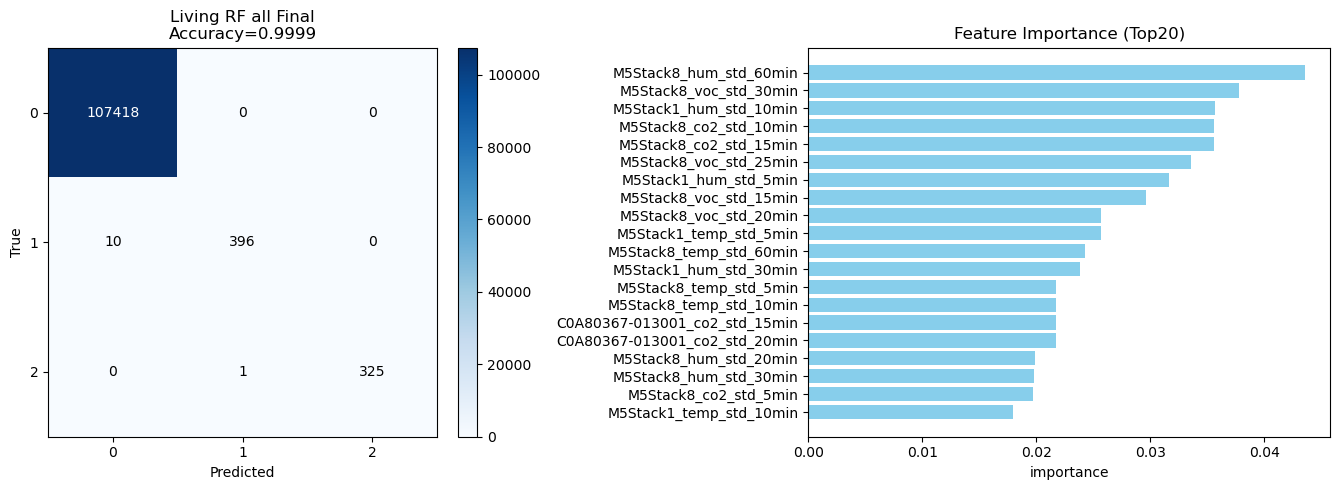

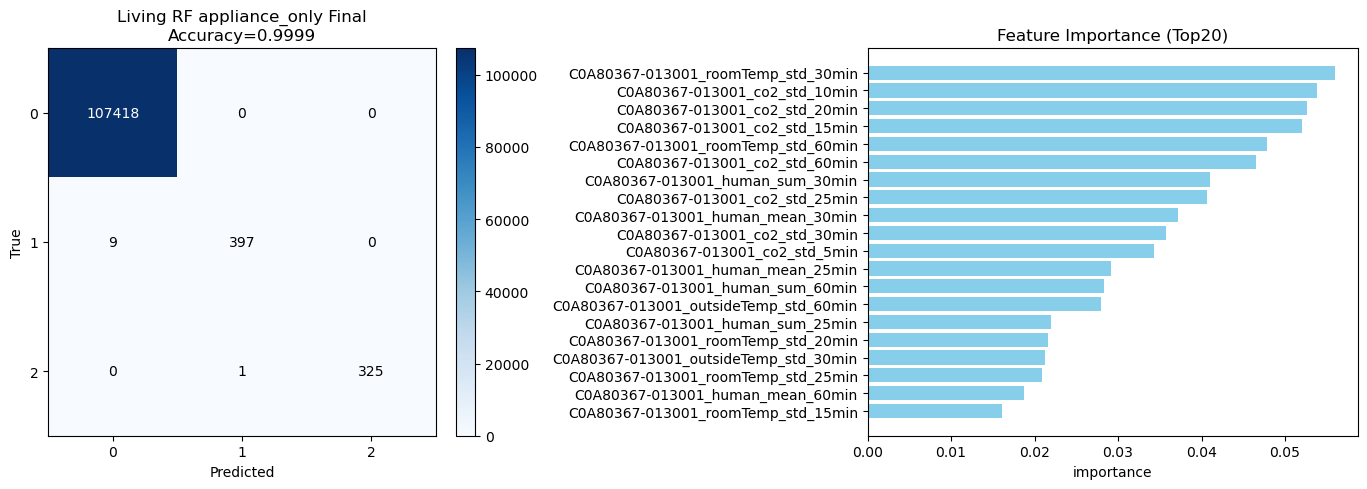

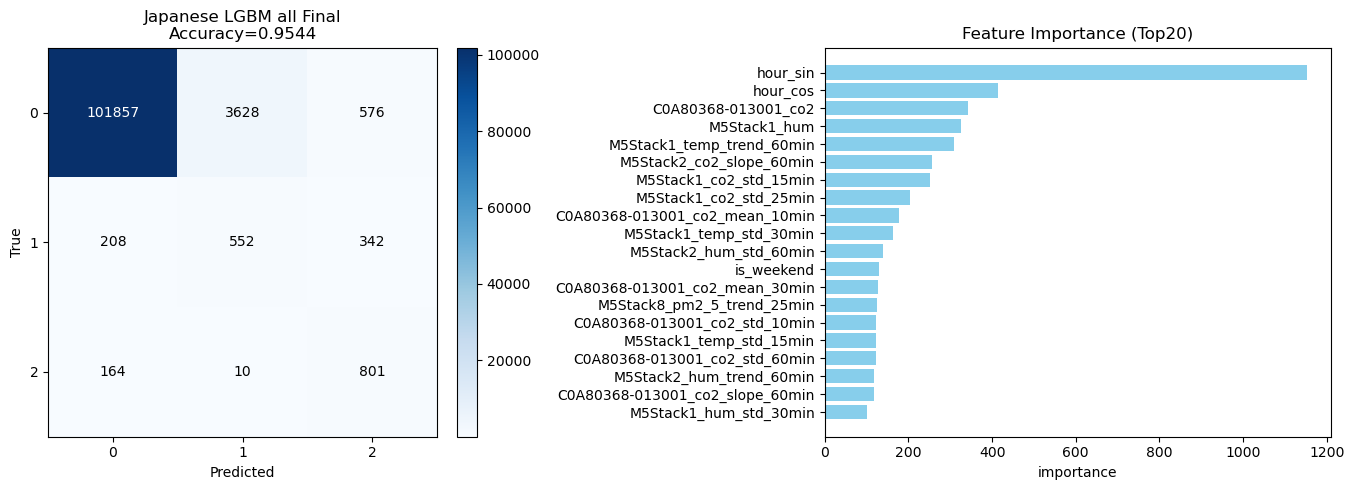

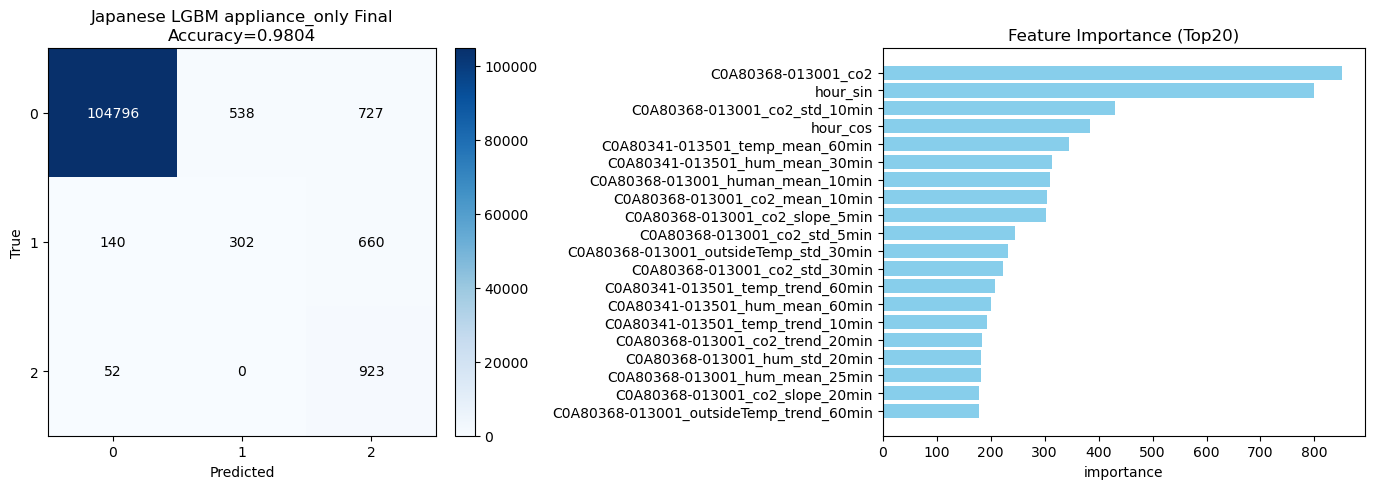

In [2]:
# ============================================================
# Smart Home Occupancy & Counting Pipeline (Final Optimized)
# ============================================================
# Features:
# 1. Advanced Feature Engineering (Rolling Trend, Slope, Integral)
# 2. Time-based Features (Hour Sin/Cos, Weekend)
# 3. Model Optimization:
#    - Living: RandomForest (GroupShuffleSplit by 30min blocks) + Smoothing
#    - Japanese: LightGBM (TimeSplit) + Threshold Tuning
# 4. Leakage Prevention (Strict separation)
# ============================================================

import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mode

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    f1_score,
)
from lightgbm import LGBMClassifier

# =========================
# Config
# =========================
# ここを修正しました
CSV_PATH = "smart_home_data.csv"
TIME_COL = "timestamp"
RESAMPLE_RULE = "1min"

# Multi-window sizes for rolling features
WINS = [5, 10, 15, 20, 25, 30, 60]
TOPK_IMPORTANCE = 20
SEED = 42

# Living RF Config
BLOCK_MINUTES = 30
TEST_RATIO = 0.20

# Appliance ID Prefixes
APPLIANCE_PREFIXES = ("C0A8033B", "C0A80341", "C0A80367", "C0A80368")


# =========================
# Utilities
# =========================
def to_dt(series: pd.Series) -> pd.Series:
    return pd.to_datetime(series, errors="coerce")


def safe_ffill(df: pd.DataFrame) -> pd.DataFrame:
    return df.ffill().infer_objects(copy=False)


def resample_1min(df: pd.DataFrame, rule="1min") -> pd.DataFrame:
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    other_cols = [c for c in df.columns if c not in num_cols]

    out = []
    if num_cols:
        out.append(df[num_cols].resample(rule).mean())
    if other_cols:
        out.append(df[other_cols].resample(rule).last())

    dfr = pd.concat(out, axis=1).sort_index()
    dfr = safe_ffill(dfr)
    dfr = dfr.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    return dfr


def coerce_boolish_to_float(s: pd.Series) -> pd.Series:
    s = s.replace({"True": 1, "False": 0, True: 1, False: 0})
    s = pd.to_numeric(s, errors="coerce")
    return s.astype(float)


def uniq(xs):
    return list(dict.fromkeys(xs))


# --- Threshold Optimization ---
def optimize_threshold(y_true, y_proba):
    best_th = 0.5
    best_score = 0
    # Search 0.1 to 0.9 for best F1 score of positive class
    for th in np.arange(0.1, 0.9, 0.05):
        y_pred = (y_proba >= th).astype(int)
        score = f1_score(y_true, y_pred, pos_label=1)
        if score > best_score:
            best_score = score
            best_th = th
    return best_th


# --- Smoothing (Post-Processing) ---
def apply_smoothing(y_pred, window=5):
    # Rolling median (majority vote for ordinal 0/1/2)
    s = pd.Series(y_pred)
    return s.rolling(window, center=True, min_periods=1).median().astype(int).values


def plot_cm_and_importance(
    title_prefix, y_true, y_pred, labels, feature_names, importances, topk=20
):
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    if hasattr(importances, "values"):  # pandas series
        imp = importances
    else:
        imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

    top = imp.head(topk)[::-1]

    fig = plt.figure(figsize=(14, 5))

    # CM
    ax1 = plt.subplot(1, 2, 1)
    im = ax1.imshow(cm, interpolation="nearest", cmap="Blues")
    ax1.set_title(f"{title_prefix}\nAccuracy={acc:.4f}")
    plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
    tick = np.arange(len(labels))
    ax1.set_xticks(tick)
    ax1.set_yticks(tick)
    ax1.set_xticklabels(labels)
    ax1.set_yticklabels(labels)
    ax1.set_xlabel("Predicted")
    ax1.set_ylabel("True")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax1.text(
                j,
                i,
                str(cm[i, j]),
                ha="center",
                va="center",
                color="black" if cm[i, j] < cm.max() / 2 else "white",
            )

    # Importance
    ax2 = plt.subplot(1, 2, 2)
    ax2.barh(top.index, top.values, color="skyblue")
    ax2.set_title(f"Feature Importance (Top{topk})")
    ax2.set_xlabel("importance")
    plt.tight_layout()
    plt.savefig(f"{title_prefix.replace(' ', '_').replace('|', '')}.png")
    # plt.show()


# =========================
# Feature Engineering
# =========================


def _rolling_linreg_slope(y: pd.Series, window: int) -> pd.Series:
    y = pd.to_numeric(y, errors="coerce").astype(float)
    w = int(window)
    if w < 3:
        return pd.Series(0.0, index=y.index)
    t = np.arange(w, dtype=float)
    t_centered = t - t.mean()
    denom = np.sum(t_centered**2)

    def slope_fn(a):
        return np.dot(t_centered, (a - a.mean())) / denom

    return y.rolling(w, min_periods=w).apply(slope_fn, raw=True).fillna(0.0)


def add_time_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    if isinstance(df.index, pd.DatetimeIndex):
        # Cyclical Hour
        df["hour_sin"] = np.sin(2 * np.pi * df.index.hour / 24.0)
        df["hour_cos"] = np.cos(2 * np.pi * df.index.hour / 24.0)
        # Weekend flag
        df["is_weekend"] = df.index.dayofweek.isin([5, 6]).astype(float)
    return df


def build_numeric_features_multiwin(
    df: pd.DataFrame, cols: list[str], wins: list[int]
) -> pd.DataFrame:
    feats = {}
    for c in cols:
        if c not in df.columns:
            continue
        s = pd.to_numeric(df[c], errors="coerce").astype(float).ffill().fillna(0.0)
        feats[c] = s

        # 1-step diff
        d1 = s.diff().fillna(0.0)
        feats[f"{c}_diff_1min"] = d1

        for w in wins:
            # Rolling stats
            r = s.rolling(w, min_periods=1)
            feats[f"{c}_mean_{w}min"] = r.mean().fillna(0.0)
            feats[f"{c}_std_{w}min"] = r.std().fillna(0.0)

            # Trends
            feats[f"{c}_slope_{w}min"] = ((s - s.shift(w)) / float(w)).fillna(0.0)
            feats[f"{c}_trend_{w}min"] = _rolling_linreg_slope(s, w)

    X = pd.DataFrame(feats, index=df.index)
    X = X.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    return X


def build_human_features(
    df: pd.DataFrame, human_cols: list[str], wins: list[int]
) -> pd.DataFrame:
    feats = {}
    for c in human_cols:
        if c not in df.columns:
            continue
        s = coerce_boolish_to_float(df[c]).ffill().fillna(0.0)
        feats[c] = s
        for w in wins:
            feats[f"{c}_sum_{w}min"] = s.rolling(w, min_periods=1).sum().fillna(0.0)

    X = pd.DataFrame(feats, index=df.index)
    X = X.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    return X


# --- Column Selection Helper ---
def pick_room_columns_latest(df: pd.DataFrame, room: str):
    if room == "Living":
        label = "Label_Living_Count"
        appliance_cols = [
            c
            for c in df.columns
            if c.startswith("C0A80367-013001_") or c.startswith("C0A8033B-013501_")
        ]
    elif room == "Japanese":
        label = "Label_Japanese_Count"
        appliance_cols = [
            c
            for c in df.columns
            if c.startswith("C0A80368-013001_") or c.startswith("C0A80341-013501_")
        ]
    else:
        raise ValueError("room must be Living or Japanese")

    m5_cols = [
        c
        for c in df.columns
        if (
            c.startswith("M5Stack1_")
            or c.startswith("M5Stack2_")
            or c.startswith("M5Stack8_")
        )
    ]
    pir_cols = [c for c in df.columns if c.lower().startswith("pir")]
    candidate_num = appliance_cols + m5_cols

    def check(name, key):
        return key in name.lower() or name.lower().endswith(f"_{key}")

    return dict(
        label=label,
        co2_cols=uniq([c for c in candidate_num if "co2" in c.lower()]),
        pm25_cols=uniq([c for c in candidate_num if "pm2" in c.lower()]),
        voc_cols=uniq([c for c in candidate_num if "voc" in c.lower()]),
        th_cols=uniq(
            [c for c in candidate_num if "temp" in c.lower() or "hum" in c.lower()]
        ),
        human_cols=uniq([c for c in candidate_num if "human" in c.lower()] + pir_cols),
        # Appliance specific subsets
        app_co2=uniq([c for c in appliance_cols if "co2" in c.lower()]),
        app_pm25=uniq([c for c in appliance_cols if "pm2" in c.lower()]),
        app_voc=uniq([c for c in appliance_cols if "voc" in c.lower()]),
        app_th=uniq(
            [c for c in appliance_cols if "temp" in c.lower() or "hum" in c.lower()]
        ),
        app_human=uniq([c for c in appliance_cols if "human" in c.lower()]),
    )


# =========================
# Japanese Room (LightGBM)
# =========================
def run_japanese_lgbm(df: pd.DataFrame, setting: str = "all"):
    room = "Japanese"
    print(f"\n>>> Running {room} Pipeline ({setting})")

    pack = pick_room_columns_latest(df, room)
    label_col = pack["label"]
    if label_col not in df.columns:
        print(f"[SKIP] {label_col} not found")
        return

    # Prepare Y
    y = pd.to_numeric(df[label_col], errors="coerce").fillna(0).astype(int)
    y = y.where(y.isin([0, 1, 2]), 0)

    # Prepare X
    if setting == "all":
        num_cols = (
            pack["co2_cols"] + pack["pm25_cols"] + pack["voc_cols"] + pack["th_cols"]
        )
        hum_cols = pack["human_cols"]
    elif setting == "appliance_only":
        num_cols = pack["app_co2"] + pack["app_pm25"] + pack["app_voc"] + pack["app_th"]
        hum_cols = pack["app_human"]
    else:
        return

    X_num = build_numeric_features_multiwin(df, num_cols, WINS)
    X_hum = build_human_features(df, hum_cols, WINS)
    X = pd.concat([X_num, X_hum], axis=1)

    # Add Time Features
    X = add_time_features(X)
    X = X.loc[:, ~X.columns.duplicated()]

    # Time Split (80/20)
    n = len(df)
    n_tr = int(n * 0.80)
    X_tr, X_te = X.iloc[:n_tr], X.iloc[n_tr:]
    y_tr, y_te = y.iloc[:n_tr], y.iloc[n_tr:]

    # --- Stage 1: Occupancy (0 vs >0) with Threshold Tuning ---
    y_tr_occ = (y_tr > 0).astype(int)
    y_te_occ = (y_te > 0).astype(int)

    occ_model = LGBMClassifier(
        objective="binary",
        n_estimators=1000,
        learning_rate=0.03,
        num_leaves=63,
        class_weight="balanced",
        random_state=SEED,
        n_jobs=-1,
        verbose=-1,
    )
    occ_model.fit(X_tr, y_tr_occ)

    # Optimize Threshold
    tr_proba = occ_model.predict_proba(X_tr)[:, 1]
    te_proba = occ_model.predict_proba(X_te)[:, 1]
    best_th = optimize_threshold(y_tr_occ, tr_proba)
    print(f"[Stage 1] Optimized Threshold: {best_th:.2f}")

    pred_occ = (te_proba >= best_th).astype(int)
    print(f"Stage 1 Accuracy: {accuracy_score(y_te_occ, pred_occ):.4f}")

    # --- Stage 2: Count (1 vs 2) ---
    tr_mask = y_tr.isin([1, 2])
    X_tr_12 = X_tr[tr_mask]
    y_tr_12 = y_tr[tr_mask]

    if len(np.unique(y_tr_12)) < 2:
        print("[WARN] Stage 2 skipped (insufficient data)")
        final_pred = np.zeros_like(y_te)
    else:
        # Map 1->0, 2->1 for binary classifier
        y_tr_map = y_tr_12.map({1: 0, 2: 1})

        cnt_model = LGBMClassifier(
            objective="binary",
            n_estimators=1000,
            learning_rate=0.03,
            num_leaves=63,
            class_weight="balanced",
            random_state=SEED,
            n_jobs=-1,
            verbose=-1,
        )
        cnt_model.fit(X_tr_12, y_tr_map)

        # Predict on all test samples
        pred_cnt_raw = cnt_model.predict(X_te)  # returns 0 or 1
        pred_cnt_mapped = pd.Series(pred_cnt_raw).map({0: 1, 1: 2}).values

        # Combine with Stage 1 result
        final_pred = np.zeros_like(y_te)
        occ_mask = pred_occ == 1
        final_pred[occ_mask] = pred_cnt_mapped[occ_mask]

    # --- Post-Processing: Smoothing ---
    final_pred_smooth = apply_smoothing(final_pred, window=5)

    print("\n--- Final Results (Smoothed) ---")
    print(f"Accuracy: {accuracy_score(y_te, final_pred_smooth):.4f}")
    print(classification_report(y_te, final_pred_smooth, digits=3, zero_division=0))

    plot_cm_and_importance(
        f"Japanese LGBM {setting} Final",
        y_te,
        final_pred_smooth,
        labels=[0, 1, 2],
        feature_names=X.columns.tolist(),
        importances=occ_model.feature_importances_,  # Show Stage 1 importance
        topk=TOPK_IMPORTANCE,
    )


# =========================
# Living Room (RandomForest)
# =========================
def make_block_groups(ts: pd.Series, block_minutes: int) -> np.ndarray:
    t0 = ts.min()
    minutes = (ts - t0).dt.total_seconds() / 60.0
    return (minutes // block_minutes).astype(int).to_numpy()


def run_living_rf(df: pd.DataFrame, setting: str = "all"):
    room = "Living"
    print(f"\n>>> Running {room} Pipeline ({setting})")

    pack = pick_room_columns_latest(df, room)
    label_col = pack["label"]
    if label_col not in df.columns:
        print(f"[SKIP] {label_col} not found")
        return

    # Prepare Y
    y = pd.to_numeric(df[label_col], errors="coerce").fillna(0).astype(int)
    y = y.where(y.isin([0, 1, 2]), 0)

    # Prepare X
    if setting == "all":
        num_cols = (
            pack["co2_cols"] + pack["pm25_cols"] + pack["voc_cols"] + pack["th_cols"]
        )
        hum_cols = pack["human_cols"]
    elif setting == "appliance_only":
        num_cols = pack["app_co2"] + pack["app_pm25"] + pack["app_voc"] + pack["app_th"]
        hum_cols = pack["app_human"]
    elif setting == "no_co2_human":
        num_cols = pack["pm25_cols"] + pack["voc_cols"] + pack["th_cols"]
        hum_cols = []
    else:
        return

    X_num = build_numeric_features_multiwin(df, num_cols, WINS)
    X_hum = build_human_features(df, hum_cols, WINS)
    X = pd.concat([X_num, X_hum], axis=1)

    # Add Time Features
    X = add_time_features(X)
    X = X.loc[:, ~X.columns.duplicated()]

    # Block Split
    groups = make_block_groups(pd.Series(df.index), BLOCK_MINUTES)
    gss = GroupShuffleSplit(n_splits=1, test_size=TEST_RATIO, random_state=SEED)
    tr_idx, te_idx = next(gss.split(X, y, groups=groups))

    X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
    y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]

    # --- Stage 1: Occupancy (0 vs >0) ---
    y_tr_occ = (y_tr > 0).astype(int)
    y_te_occ = (y_te > 0).astype(int)

    occ_model = RandomForestClassifier(
        n_estimators=500,
        class_weight="balanced_subsample",
        min_samples_leaf=2,
        random_state=SEED,
        n_jobs=-1,
    )
    occ_model.fit(X_tr, y_tr_occ)

    # Threshold Tuning
    tr_proba = occ_model.predict_proba(X_tr)[:, 1]
    te_proba = occ_model.predict_proba(X_te)[:, 1]
    best_th = optimize_threshold(y_tr_occ, tr_proba)
    print(f"[Stage 1] Optimized Threshold: {best_th:.2f}")

    pred_occ = (te_proba >= best_th).astype(int)
    print(f"Stage 1 Accuracy: {accuracy_score(y_te_occ, pred_occ):.4f}")

    # --- Stage 2: Count (1 vs 2) ---
    tr_mask = y_tr.isin([1, 2])
    X_tr_12 = X_tr[tr_mask]
    y_tr_12 = y_tr[tr_mask]

    if len(np.unique(y_tr_12)) < 2:
        print("[WARN] Stage 2 skipped")
        final_pred = np.zeros_like(y_te)
    else:
        cnt_model = RandomForestClassifier(
            n_estimators=500,
            class_weight="balanced_subsample",
            min_samples_leaf=2,
            random_state=SEED,
            n_jobs=-1,
        )
        cnt_model.fit(X_tr_12, y_tr_12)

        pred_cnt_all = cnt_model.predict(X_te)

        # Combine
        final_pred = np.zeros_like(y_te)
        occ_mask = pred_occ == 1
        final_pred[occ_mask] = pred_cnt_all[occ_mask]

    # --- Smoothing ---
    final_pred_smooth = apply_smoothing(final_pred, window=5)

    print("\n--- Final Results (Smoothed) ---")
    print(f"Accuracy: {accuracy_score(y_te, final_pred_smooth):.4f}")
    print(classification_report(y_te, final_pred_smooth, digits=3, zero_division=0))

    plot_cm_and_importance(
        f"Living RF {setting} Final",
        y_te,
        final_pred_smooth,
        labels=[0, 1, 2],
        feature_names=X.columns.tolist(),
        importances=occ_model.feature_importances_,
        topk=TOPK_IMPORTANCE,
    )


# =========================
# Main Execution
# =========================
if __name__ == "__main__":
    print("📥 Loading CSV...")
    try:
        # utf-8がデフォルトですが、エラーハンドリング付きで読み込むことも可能です
        df0 = pd.read_csv(CSV_PATH, low_memory=False)
    except FileNotFoundError:
        print(f"Error: {CSV_PATH} not found.")
        exit()
    except UnicodeDecodeError:
        print("Encoding error. Trying 'cp932'...")
        df0 = pd.read_csv(CSV_PATH, low_memory=False, encoding="cp932")

    if TIME_COL not in df0.columns:
        print(f"Error: {TIME_COL} missing.")
        exit()

    df0[TIME_COL] = to_dt(df0[TIME_COL])
    df0 = df0.dropna(subset=[TIME_COL]).sort_values(TIME_COL).set_index(TIME_COL)

    # Preprocessing
    df = resample_1min(df0, RESAMPLE_RULE)

    # Run Pipelines
    # 1. Living (RF) - Try different settings
    for setting in ["all", "appliance_only"]:
        run_living_rf(df, setting)

    # 2. Japanese (LightGBM)
    for setting in ["all", "appliance_only"]:
        run_japanese_lgbm(df, setting)

    print("\n✅ All Done.")